In [15]:
# Version check. Written for Python 3.5.4
import sys
print(sys.version)
# 3.8.5 (default, Sep  4 2020, 02:22:02) 
# [Clang 10.0.0 ]


3.8.5 (default, Sep  4 2020, 02:22:02) 
[Clang 10.0.0 ]


In [16]:
import matplotlib
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib.axes as axes
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from sympy import *
from sympy.utilities.autowrap import autowrap
import re

%matplotlib inline

In [17]:
DATE = "20220520"
MNR = "M002"
DESCR = ""

In [30]:
# Define the path to the input folder containing the output parameters
inputFolder = "/Users/muriel/Documents/LACDR/Projects/LMS/DDRmodel/Output/M002/CDDP/20210409/Run1/" # Write down the path to the folder that
# contains the parameter estimates of all the finished runs

# Define the path to the parameter estimates
fileName = "20210409_MH_M002Model_parameterEstimates_parmset7_cost_81.60.csv" # 

# Read in the file with the parameter estimates
file = inputFolder+fileName

outputPath = "/Users/muriel/Documents/LACDR/Projects/LMS/DDRmodel/Output/Figures/"

In [19]:
# Define the parameters
parameterEst = pd.read_csv(file)

pAllNew = parameterEst["est_value"].values

# Make the parameters global variables
for i in parameterEst.iterrows():
    sText = str(parameterEst.iloc[i[0], 0]) + " = " + str(parameterEst.iloc[i[0], 2])
    print(sText)
    exec(sText)
    
EC1 = 1


DD_ss = 21.44273094716252
P53_ss = 0.20393030377293295
P53P_ss = 0.3419058481014804
MDM2_ss = 0.26255102920372075
P21_ss = 4.686343829876266
BTG2_ss = 5.1564640958233685
EC2 = 2.5204280180892837
EC3 = 6.307280646327338
tau1 = 0.03048445717161853
kd_dd = 0.062375358818728424
k_dp = 0.6145469418693293
kd_p53 = 0.07110570525068577
kd_p53p = 0.000321822146912136
kd_p53_mdm2 = 3.691141631466161e-05
kd_p53p_mdm2 = 0.10386034632799301
ks_mdm2 = 0.000392827973846765
ks_mdm2_p53p = 0.05011867014563642
ks_p21 = 0.012410162903513669
ks_p21_p53p = 0.2563077718624401
Km_mdm2 = 0.29618423245239434
Km_p21 = 0.7405193230455089
Km_btg2 = 0.3815517800433708
ks_btg2 = 0.14387901804701836
ks_btg2_p53p = 0.5548002152574245
sf_p53 = 16.881626455967194
sf_mdm2 = 5.389987878517923
sf_p21 = 0.2913283490637697
sf_btg2 = 0.15422189082803514
offset_p53 = -9.157445613053797
offset_mdm2 = -1.32427832738993
offset_p21 = -1.3085851778745727
offset_btg2 = -0.7834022802745606
ks_dd = 0.4572984006344495
k_p = 0.05020796

In [20]:
# Define ODE model
def p53signaling(z,t,args):
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53 = ks_p53 + k_dp * P53P - k_p * P53 * DD - kd_p53 * P53 - kd_p53_mdm2 * MDM2 * P53
    dP53P = k_p * P53 * DD - k_dp * P53P - kd_p53p * P53P - kd_p53p_mdm2 * MDM2 * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

In [21]:
# Stress level decrease
def sFunction(s_init,r,t):
    out = s_init * np.exp(-r*t)
    return out

In [31]:
def facetplot_1col(sol, varnames, plot_title,color, title = "",
                    file = "Fig1"):
    nrows = len(varnames)
    fig, ax = plt.subplots(nrows,1,sharex=True, sharey='row')
    
    for row in range(0,nrows):
        ax[row].plot(t*1.5,sol[:,row], color = color, linewidth = 4)
        ax[row].tick_params(axis = 'both', labelsize=16)
        ax[row].locator_params(axis='y', nbins=4)
                
    for row in range(0,nrows):
        ax[row].set_ylabel(varnames[row], rotation = -90, fontsize = 22)
        ax[row].yaxis.set_label_coords(1.03,0.5)
    
    ax[0].set_title(plot_title,fontdict={'fontsize': 28}, pad=20)
    
    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(16)
    fig.set_figwidth(3.5)
    if not title == "":
        fig.suptitle(title, fontsize = 24)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=28, labelpad=16)
    plt.ylabel("Simulated intensity (a.u.)", fontsize=28, labelpad=28)
    
    fig.savefig(outputPath + file + ".pdf", bbox_inches='tight')
    
    

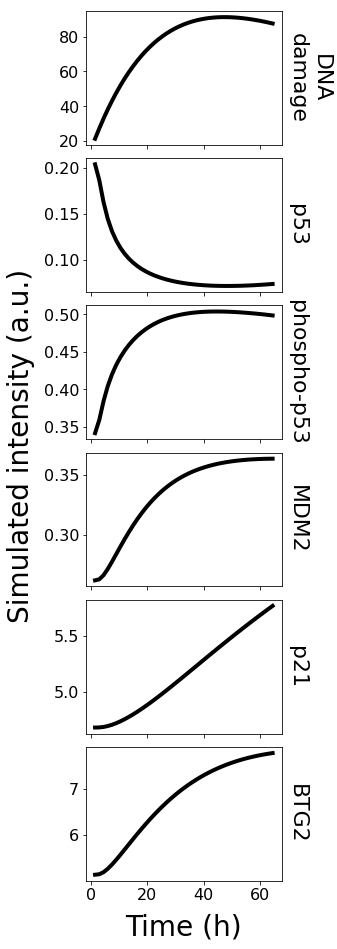

In [33]:
# initial condition
z = [DD_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,43,43)

# solve ODE
dzdt_Control = odeint(p53signaling,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC3],))


facetplot_1col(sol = dzdt_Cisplatin3, 
               varnames = ["DNA\ndamage","p53","phospho-p53","MDM2","p21","BTG2"],
               plot_title = "",
              color = "black",
              file = "FigureS4_M002_model_simulation")

In [12]:
# initial condition
z = [DD_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,443,443)

# solve ODE
dzdt_Control = odeint(p53signaling,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3 = odeint(p53signaling,z,t, args = ([sFunction,tau1,EC3],))
dzdt_Cisplatin4 = odeint(p53signaling,z,t, args = ([sFunction,tau1,0.000001],))

In [13]:
stressLevels = [0,EC1,EC2,EC3]

sols = list()
for stressLevel in stressLevels:
    # solve ODE
    dzdt = odeint(p53signaling,z,t, args = ([sFunction,tau1,stressLevel],))
    sols.append(dzdt)


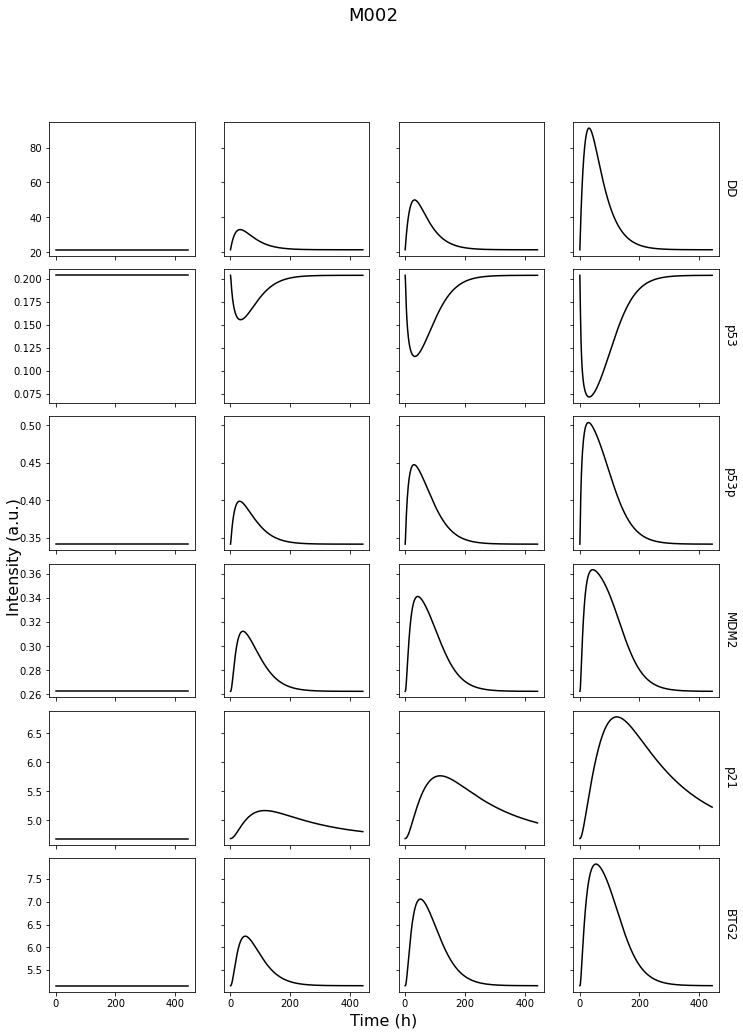

In [14]:
facetplot([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
          ["DD","p53","p53p","MDM2","p21","BTG2"],
         title = MNR)

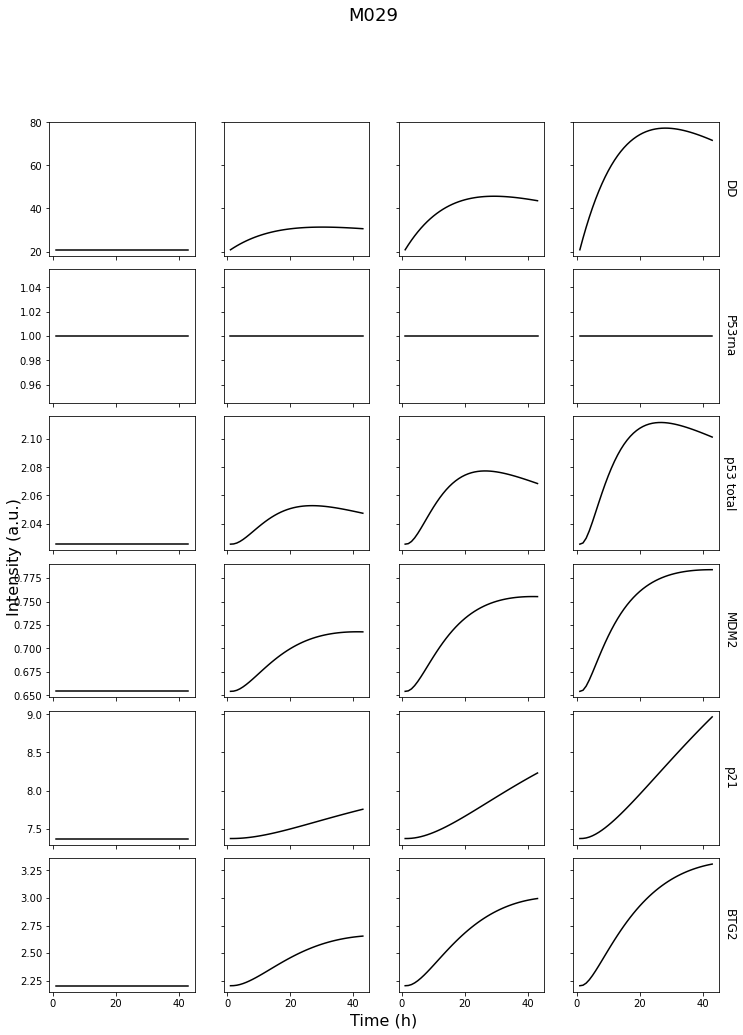

In [23]:
facetplot_addP53([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
                 ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
                 ["DD","P53rna","p53 total","MDM2","p21","BTG2"],
                 title = MNR)

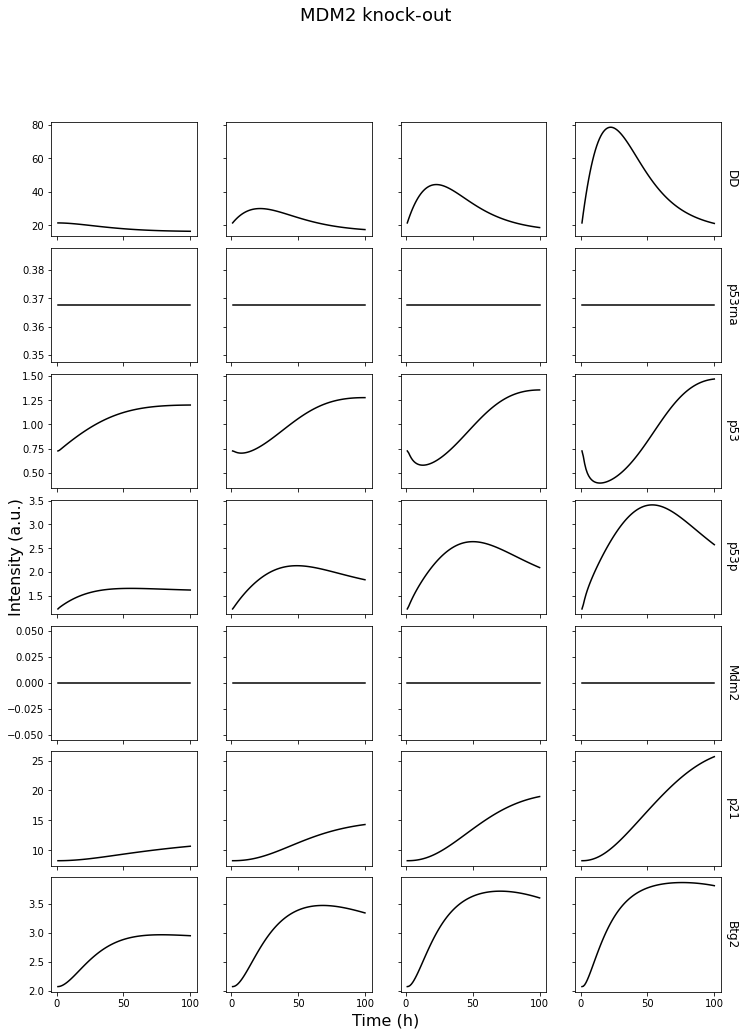

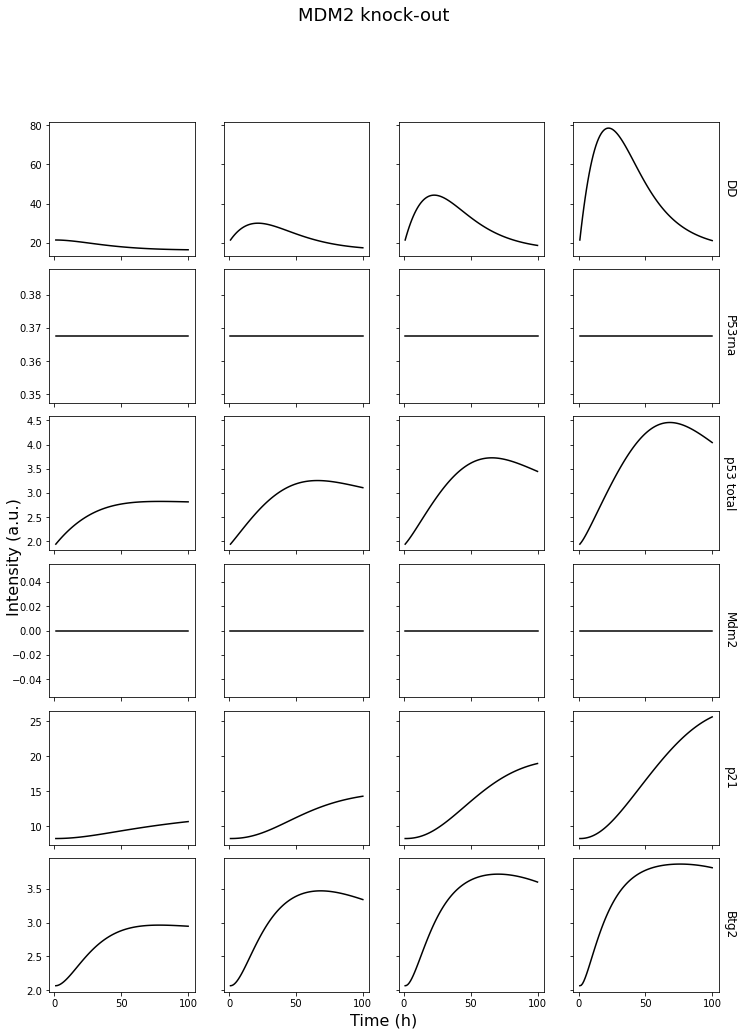

In [18]:
### MDM2 knockdown
# Define ODE model
MDM2_kd = 0
def mdm2_knockdown(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - kd_p53_by_mdm2 * MDM2 * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - kd_p53p_by_mdm2 * MDM2 * P53P
    dMDM2 = 0 #(ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2)
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt
# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_kd,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,100,100)

# solve ODE
dzdt_Control = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1 = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2 = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3 = odeint(mdm2_knockdown,z,t, args = ([sFunction,tau1,EC3],))

facetplot([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
          ["DD","p53rna","p53","p53p","Mdm2","p21","Btg2"],
         title = "MDM2 knock-out")

facetplot_addP53([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
                 ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
                 ["DD","P53rna","p53 total","Mdm2","p21","Btg2"],
                 title = "MDM2 knock-out")

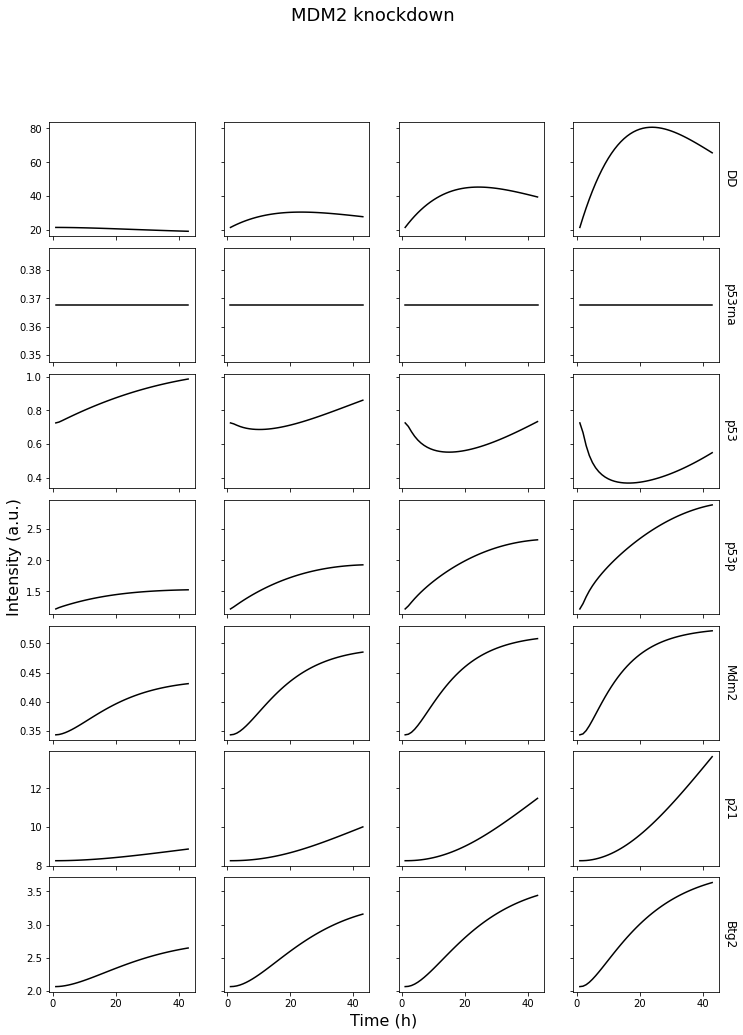

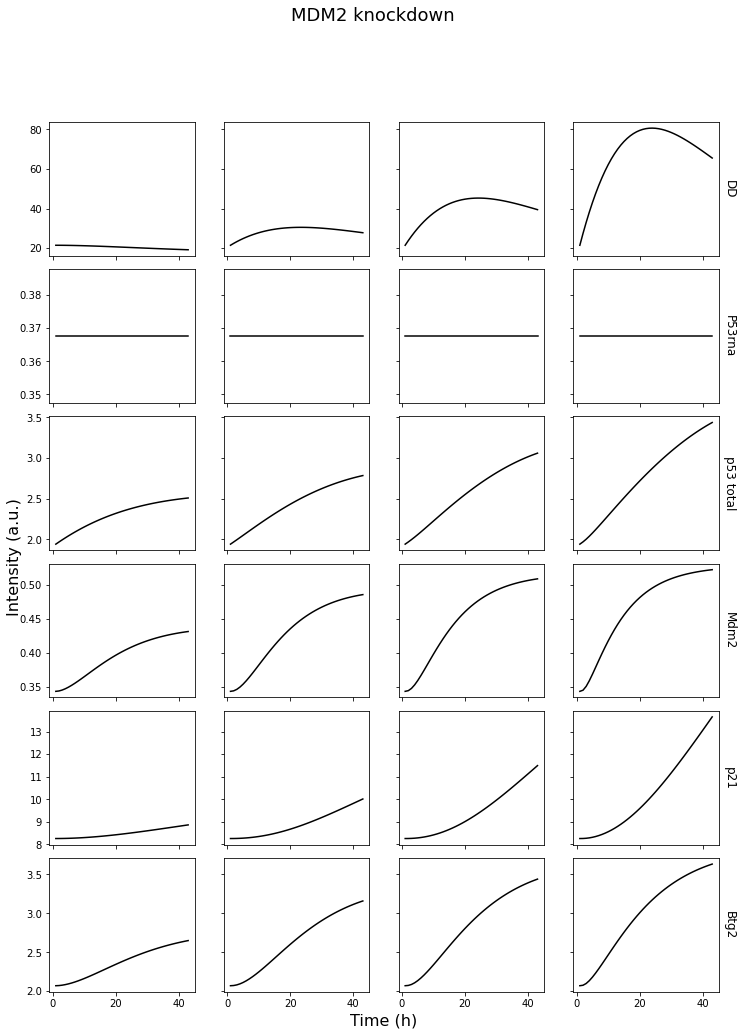

In [19]:
### MDM2 knockdown 2
# Define ODE model
#kd_p53_by_mdm2 = 1.9896754830043367e-05 *10
#kd_p53p_by_mdm2 = 0.07932107498586342
def mdm2_knockdown2(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - 0.2 *  kd_p53_by_mdm2 * MDM2 * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - 0.2 * kd_p53p_by_mdm2 * MDM2 * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,43,43)

# solve ODE
dzdt_Control = odeint(mdm2_knockdown2,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1 = odeint(mdm2_knockdown2,z,t, args = ([sFunction,tau1,EC1],))
dzdt_Cisplatin2 = odeint(mdm2_knockdown2,z,t, args = ([sFunction,tau1,EC2],))
dzdt_Cisplatin3 = odeint(mdm2_knockdown2,z,t, args = ([sFunction,tau1,EC3],))

facetplot([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
          ["DD","p53rna","p53","p53p","Mdm2","p21","Btg2"],
         title = "MDM2 knockdown")
facetplot_addP53([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
                 ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
                 ["DD","P53rna","p53 total","Mdm2","p21","Btg2"],
                 title = "MDM2 knockdown")

In [20]:
def facetplot(solList, varnames, plot_titles, title = "Model"):
    nrows = len(varnames)
    ncols = len(solList)
    fig, ax = plt.subplots(nrows,ncols,sharex=True, sharey='row')

    for i,sol in enumerate(solList):
        for row in range(0,nrows):
            ax[row,i].plot(t,sol[:,row], color = "#000000")
    
    for row in range(0,nrows):
        ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
        ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)
    
    for j,pt in enumerate(plot_titles):
        ax[0, j].set_title(pt,
                           fontdict={'fontsize': 24}, pad=20)

    # add a big axes, hide frame
    fig.add_subplot(111, frameon=False)
    fig.subplots_adjust(hspace=0.1)
    fig.set_figheight(16)
    fig.set_figwidth(12)
    fig.suptitle(title, fontsize = 18)

    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("Time (h)", fontsize=16)
    plt.ylabel("Intensity (a.u.)", fontsize=16)

In [21]:
dd = dzdt_Control[::,0]
p53_rna = dzdt_Control[::,1]
p53_tot = sf_p53 * (dzdt_Control[::,2] + dzdt_Control[::,3]) + offset_p53
mdm2 = sf_mdm2 * dzdt_Control[::,4] + offset_mdm2
p21 = sf_p21 * dzdt_Control[::,5] + offset_p21
btg2 = sf_btg2 * dzdt_Control[::,6] + offset_btg2
scaled_Control = np.vstack((dd,p53_rna, p53_tot,mdm2,p21,btg2)).T

dd = dzdt_Cisplatin1[::,0]
p53_rna = dzdt_Cisplatin1[::,1]
p53_tot = sf_p53 * (dzdt_Cisplatin1[::,2] + dzdt_Cisplatin1[::,3]) + offset_p53
mdm2 = sf_mdm2 * dzdt_Cisplatin1[::,4] + offset_mdm2
p21 = sf_p21 * dzdt_Cisplatin1[::,5] + offset_p21
btg2 = sf_btg2 * dzdt_Cisplatin1[::,6] + offset_btg2
scaled_Cisplatin1 = np.vstack((dd,p53_rna, p53_tot,mdm2,p21,btg2)).T

dd = dzdt_Cisplatin2[::,0]
p53_rna = dzdt_Cisplatin2[::,1]
p53_tot = sf_p53 * (dzdt_Cisplatin2[::,2] + dzdt_Cisplatin2[::,3]) + offset_p53
mdm2 = sf_mdm2 * dzdt_Cisplatin2[::,4] + offset_mdm2
p21 = sf_p21 * dzdt_Cisplatin2[::,5] + offset_p21
btg2 = sf_btg2 * dzdt_Cisplatin2[::,6] + offset_btg2
scaled_Cisplatin2 = np.vstack((dd,p53_rna, p53_tot,mdm2,p21,btg2)).T

dd = dzdt_Cisplatin3[::,0]
p53_rna = dzdt_Cisplatin3[::,1]
p53_tot = sf_p53 * (dzdt_Cisplatin3[::,2] + dzdt_Cisplatin3[::,3]) + offset_p53
mdm2 = sf_mdm2 * dzdt_Cisplatin3[::,4] + offset_mdm2
p21 = sf_p21 * dzdt_Cisplatin3[::,5] + offset_p21
btg2 = sf_btg2 * dzdt_Cisplatin3[::,6] + offset_btg2
scaled_Cisplatin3 = np.vstack((dd,p53_rna, p53_tot,mdm2,p21,btg2)).T

scaled_Cisplatin3;

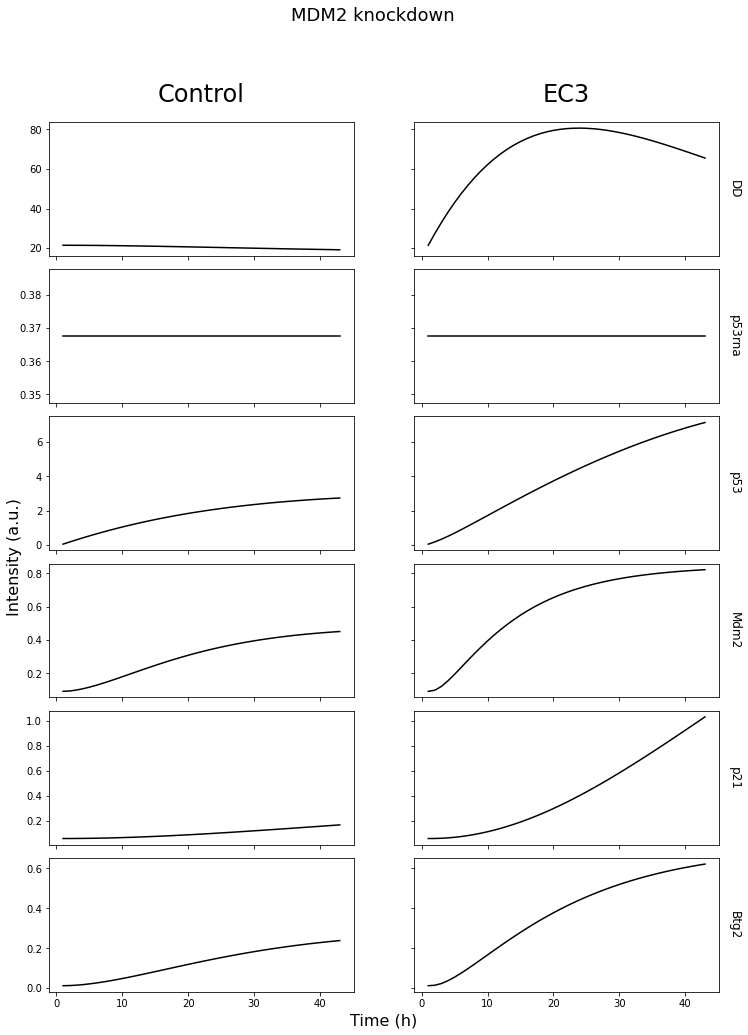

In [22]:
facetplot([scaled_Control,scaled_Cisplatin3], 
          ["DD","p53rna","p53","Mdm2","p21","Btg2"],
          plot_titles = ["Control", "EC3"],
            title = "MDM2 knockdown")

In [23]:
t = np.linspace(1,48,48)
72/1.5

48.0

In [24]:
EC3

6.3082558749113655

1.3730692614775104


(0.0, 6.3082558749113655)

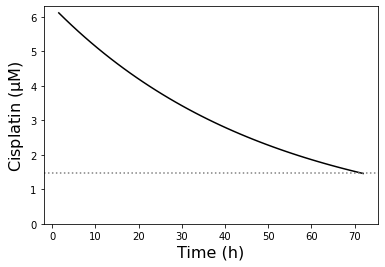

In [25]:
print(sFunction(EC3,tau1,50))
rest = sFunction(EC3,tau1,48)
plt.plot(t*1.5,sFunction(EC3,tau1,t), color = "k")
plt.axhline(y = rest, color = "grey", linestyle = "dotted")
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("Cisplatin ($\mathrm{\mu M}$)", fontsize=16)
plt.ylim(0,EC3)

In [26]:
### Cisplatin reexposure
# Define ODE model

def cisplatin_reexp(z,t,args):
    # Define ODE model
    [sFunction, r, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,r,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - kd_p53_by_mdm2 * MDM2 * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - kd_p53p_by_mdm2 * MDM2 * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,16,16)

# solve ODE
dzdt_Control = odeint(cisplatin_reexp,z,t, args = ([sFunction,tau1,0],))

dzdt_Cisplatin1 = odeint(cisplatin_reexp,z,t, args = ([sFunction,tau1,sFunction(EC1,tau1,48)],))
dzdt_Cisplatin2 = odeint(cisplatin_reexp,z,t, args = ([sFunction,tau1,sFunction(EC2,tau1,48)],))
dzdt_Cisplatin3 = odeint(cisplatin_reexp,z,t, args = ([sFunction,tau1,sFunction(EC3,tau1,48)],))

facetplot([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
          ["DD","p53rna","p53","p53p","Mdm2","p21","Btg2"],
         title = "Cisplatin reexposure")

facetplot_addP53([dzdt_Control,dzdt_Cisplatin1,dzdt_Cisplatin2,dzdt_Cisplatin3], 
                 ["DD","P53rna","p53","p53p","Mdm2","p21","Btg2"],
                 ["DD","P53rna","p53 total","Mdm2","p21","Btg2"],
                 title = "Cisplatin reexposure")

TypeError: facetplot() missing 1 required positional argument: 'plot_titles'

In [27]:
stressLevels = [0,sFunction(EC1,tau1,48),sFunction(EC2,tau1,48),sFunction(15,tau1,48)]

sols = list()
for stressLevel in stressLevels:
    # solve ODE
    print(stressLevel)
    dzdt = odeint(cisplatin_reexp,z,t, args = ([sFunction,tau1,stressLevel],))
    sols.append(dzdt)

#sols

0
0.2313512328918874
0.5831362513248475
3.470268493378311


In [28]:
obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']
scaled_sols = list()
for dosei in range(0,len(stressLevels)):
    scaled_sols.append(np.zeros([16,len(obsStateVarList)]))
for dosei in range(0,len(stressLevels)):
    scaled_sols[dosei][:,0] = sf_p53 * (sols[dosei][:,2] + sols[dosei][:,3]) + offset_p53
    scaled_sols[dosei][:,1] = sf_mdm2 * (sols[dosei][:,4]) + offset_mdm2
    scaled_sols[dosei][:,2] = sf_p21 * (sols[dosei][:,5]) + offset_p21
    scaled_sols[dosei][:,3] = sf_btg2 * (sols[dosei][:,6]) + offset_btg2

# facetplot([scaled_sols[0],scaled_sols[2]], 
#           ["p53","p21"])

In [29]:
scaled_sols[0][:,0]

array([0.057152, 0.057152, 0.057152, 0.057152, 0.057152, 0.057152,
       0.057152, 0.057152, 0.057152, 0.057152, 0.057152, 0.057152,
       0.057152, 0.057152, 0.057152, 0.057152])

Text(0, 0.5, 'GFP intensity (a.u.)')

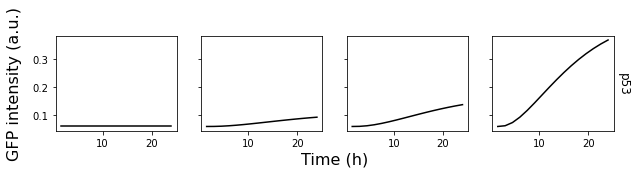

In [30]:
solList = [scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]]
varnames = ["p53","mdm2","p21","btg2"]
ylims = [[0,0.225],[0,0.04]]
title = ""

nrows = 4
ncols = 4

fig, ax = plt.subplots(1,ncols,sharex=True, sharey='row')

for i,sol in enumerate(solList):
    ax[i].plot(t*1.5,sol[:,0], color = "#000000")
    #ax[row,i].set_ylim(ylims[row])

ax[ncols-1].set_ylabel(varnames[0], rotation = -90, fontsize = 12)
ax[ncols-1].yaxis.set_label_coords(1.03,0.5)

# for row in range(0,nrows):
#     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
#     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(1.75)
fig.set_figwidth(10)
fig.suptitle(title, fontsize = 18)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("GFP intensity (a.u.)", fontsize=16)

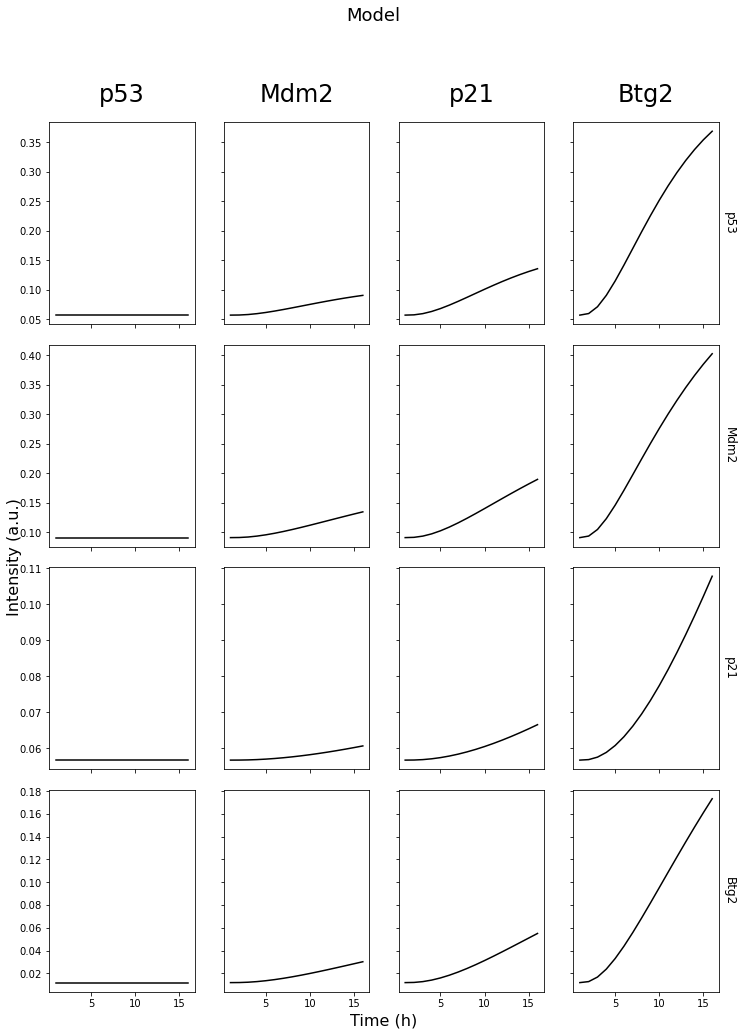

In [37]:
facetplot([scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]], 
          ["p53","Mdm2","p21","Btg2"],
          plot_titles = ["p53","Mdm2","p21","Btg2"])

In [32]:
# Change r ans checkout result on p53 and Mdm2 protein in steady state

In [33]:
### MDM2 knockdown 2
# Define ODE model
def mdm2_knockdown2(z,t,args):
    # Define ODE model
    [sFunction, tau, s_init,r] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,tau,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - r *  kd_p53_by_mdm2 * MDM2 * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - r * kd_p53p_by_mdm2 * MDM2 * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

# rlist
rlist = [0.01,0.1,1,10,100]


In [34]:
from scipy.optimize import fsolve
from matplotlib import colors
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

p53rna = []
p53total = []
mdm2total = []
p53only = []
p53ponly = []
for r in rlist:
    eq = fsolve(mdm2_knockdown2, [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss], args=(0, [sFunction, tau1, 0,r]))
    #eq
    p53tot = eq[2]+eq[3]
    mdm2 = eq[4]
    
    p53rna.append(eq[1])
    p53only.append(eq[2])
    p53ponly.append(eq[3])
    p53total.append(p53tot)
    mdm2total.append(mdm2)

#p53rna

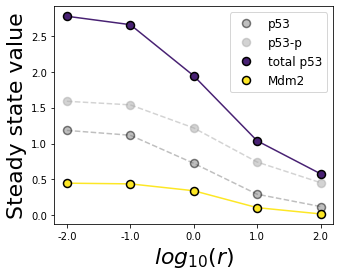

In [38]:
viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,10)
viridis(reps[1])

figureSize = (5,4)
f1 = plt.figure(figsize = figureSize)

# plt.plot(np.log10(rlist),p53rna, "--", color = 'grey', alpha = 0.5)
# plt.plot(np.log10(rlist),p53rna, "o", label = 'p53', markersize=8, markerfacecolor=viridis(reps[5]),
#              markeredgewidth=1.5, markeredgecolor="k", alpha = 0.5)

plt.plot(np.log10(rlist),p53only, "--", color = 'grey', alpha = 0.5)
plt.plot(np.log10(rlist),p53only, "o", label = 'p53', markersize=8, markerfacecolor='grey',
             markeredgewidth=1.5, markeredgecolor="k", alpha = 0.5)

plt.plot(np.log10(rlist),p53ponly, "--", color = 'darkgrey', alpha = 0.5)
plt.plot(np.log10(rlist),p53ponly, "o", label = 'p53-p', markersize=8, markerfacecolor='darkgrey',
             markeredgewidth=1.5, markeredgecolor="darkgrey", alpha = 0.5)

plt.plot(np.log10(rlist),p53total, "-", color = viridis(reps[1]))
plt.plot(np.log10(rlist),p53total, "o", label = 'total p53', markersize=8, markerfacecolor=viridis(reps[1]),
             markeredgewidth=1.5, markeredgecolor="k")

plt.plot(np.log10(rlist),mdm2total, "-", color = viridis(reps[9]))
plt.plot(np.log10(rlist),mdm2total, "o", label = 'Mdm2', markersize=8, markerfacecolor=viridis(reps[9]),
             markeredgewidth=1.5, markeredgecolor="k")

plt.xlabel('$log_{10}(r)$', fontsize=22)
plt.ylabel("Steady state value", fontsize=22)
#plt.ylabel('Mdm2', fontsize=22, color = 'blue')
plt.legend(fontsize=12)
#plt.xlim(0,(t)[-1]+5)
#plt.title("r = " + str(r), fontsize=24)
plt.xticks(np.log10(rlist),np.log10(rlist))
#plt.ylim(0,12)
plt.show()
f1.savefig("/Users/muriel/Documents/LACDR/Projects/DDP/Modeling/03_p53Model/Output/SteadyState_changing_r.pdf", bbox_inches='tight')



In [ ]:
# Change r and checkout result on p53 protein at 0 to 5 uM with actual model

In [396]:
### MDM2 knockdown 2
# Define ODE model
def mdm2_knockdown_r(z,t,args):
    # Define ODE model
    [sFunction, tau, s_init,r] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,tau,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - r *  kd_p53_by_mdm2 * MDM2 * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - r * kd_p53p_by_mdm2 * MDM2 * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

# rlist
rlist = [1,0.75,0.5,0.25,0]

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,43,43)

stressLevels = [0,EC1,EC2,EC3]

rsols = list()
for r in rlist:
    #print(r)
    sols = list()
    for stressLevel in stressLevels:
        # solve ODE
        #print(stressLevel)
        dzdt = odeint(mdm2_knockdown_r,z,t, args = ([sFunction,tau1,stressLevel,r],))
        sols.append(dzdt)
    rsols.append(sols)

In [397]:
rscaled_sols = []
for i,r in enumerate(rlist):
    obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']
    scaled_sols = list()
    for dosei in range(0,len(stressLevels)):
        scaled_sols.append(np.zeros([43,len(obsStateVarList)]))
    for dosei in range(0,len(stressLevels)):
        scaled_sols[dosei][:,0] = sf_p53 * (rsols[i][dosei][:,2] + rsols[i][dosei][:,3]) + offset_p53
        scaled_sols[dosei][:,1] = sf_mdm2 * (rsols[i][dosei][:,4]) + offset_mdm2
        scaled_sols[dosei][:,2] = sf_p21 * (rsols[i][dosei][:,5]) + offset_p21
        scaled_sols[dosei][:,3] = sf_btg2 * (rsols[i][dosei][:,6]) + offset_btg2
    rscaled_sols.append(scaled_sols)

Text(0, 0.5, 'GFP intensity (a.u.)')

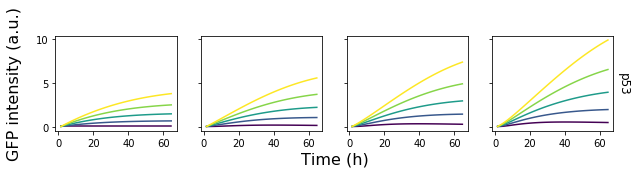

In [398]:
viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,len(rlist))
viridis(reps[1])

#solList = [scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]]
varnames = ["p53","mdm2","p21","btg2"]
ylims = [[0,0.225],[0,0.04]]
title = ""

nrows = 4
ncols = 4

fig, ax = plt.subplots(1,ncols,sharex=True, sharey='row')

for a,r in enumerate(rlist):
    b = a# abs(a-len(rlist)+1)
    solList = rscaled_sols[a]
    for i,sol in enumerate(solList):
        ax[i].plot(t*1.5,sol[:,0], color = viridis(reps[b])) #"#000000")
        #ax[row,i].set_ylim(ylims[row])

    ax[ncols-1].set_ylabel(varnames[0], rotation = -90, fontsize = 12)
    ax[ncols-1].yaxis.set_label_coords(1.03,0.5)

# for row in range(0,nrows):
#     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
#     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(1.75)
fig.set_figwidth(10)
fig.suptitle(title, fontsize = 18)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("GFP intensity (a.u.)", fontsize=16)

In [353]:
# Change r and checkout result on p53 protein at 0 to 5 uM with S-dependent r effect

In [399]:
### MDM2 knockdown 2
# Define ODE model
def mdm2_knockdown_r(z,t,args):
    # Define ODE model
    [sFunction, tau, s_init,r] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,tau,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - r/(S**2+1) *  kd_p53_by_mdm2 * MDM2 * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - r/(S**2+1) * kd_p53p_by_mdm2 * MDM2 * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

# rlist
rlist = [1,0.75,0.5,0.25,0]

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,43,43)

stressLevels = [0,EC1,EC2,EC3]

rsols = list()
for r in rlist:
    #print(r)
    sols = list()
    for stressLevel in stressLevels:
        # solve ODE
        #print(stressLevel)
        dzdt = odeint(mdm2_knockdown_r,z,t, args = ([sFunction,tau1,stressLevel,r],))
        sols.append(dzdt)
    rsols.append(sols)

In [400]:
rscaled_sols = []
for i,r in enumerate(rlist):
    obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']
    scaled_sols = list()
    for dosei in range(0,len(stressLevels)):
        scaled_sols.append(np.zeros([43,len(obsStateVarList)]))
    for dosei in range(0,len(stressLevels)):
        scaled_sols[dosei][:,0] = sf_p53 * (rsols[i][dosei][:,2] + rsols[i][dosei][:,3]) + offset_p53
        scaled_sols[dosei][:,1] = sf_mdm2 * (rsols[i][dosei][:,4]) + offset_mdm2
        scaled_sols[dosei][:,2] = sf_p21 * (rsols[i][dosei][:,5]) + offset_p21
        scaled_sols[dosei][:,3] = sf_btg2 * (rsols[i][dosei][:,6]) + offset_btg2
    rscaled_sols.append(scaled_sols)

Text(0, 0.5, 'GFP intensity (a.u.)')

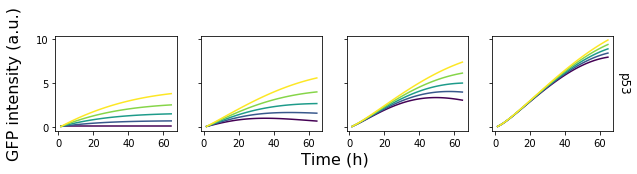

In [402]:
viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,len(rlist))
viridis(reps[1])

#solList = [scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]]
varnames = ["p53","mdm2","p21","btg2"]
ylims = [[0,0.225],[0,0.04]]
title = ""

nrows = 4
ncols = 4

fig, ax = plt.subplots(1,ncols,sharex=True, sharey='row')

for a,r in enumerate(rlist):
    b = a #abs(a-len(rlist)+1)
    solList = rscaled_sols[a]
    for i,sol in enumerate(solList):
        ax[i].plot(t*1.5,sol[:,0], color = viridis(reps[b])) #"#000000")
        #ax[row,i].set_ylim(ylims[row])

    ax[ncols-1].set_ylabel(varnames[0], rotation = -90, fontsize = 12)
    ax[ncols-1].yaxis.set_label_coords(1.03,0.5)

# for row in range(0,nrows):
#     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
#     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(1.75)
fig.set_figwidth(10)
fig.suptitle(title, fontsize = 18)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("GFP intensity (a.u.)", fontsize=16)

In [703]:
ks_mdm2_by_p53p

0.06580204934309652

In [ ]:
# Change r and checkout result on p53 protein at 0 to 5 uM with other mdm2-feedback r effect

In [757]:
### MDM2 knockdown 2
# Define ODE model
def mdm2_knockdown_r(z,t,args):
    # Define ODE model
    [sFunction, tau, s_init,r] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,tau,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - kd_p53_by_mdm2 * (MDM2 ) * P53 * r
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - kd_p53p_by_mdm2 * (MDM2 ) * P53P * r
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

# rlist
rlist = [1,0]#[1, 0.75,0.5,0.25,0]
ks_mdm2_by_p53p = 0.06580204934309652 * 1
kd_mdm2 = 0

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,43,43)

stressLevels = [0,EC1,EC2,EC3]

rsols = list()
for r in rlist:
    #print(r)
    sols = list()
    for stressLevel in stressLevels:
        # solve ODE
        #print(stressLevel)
        dzdt = odeint(mdm2_knockdown_r,z,t, args = ([sFunction,tau1,stressLevel,r],))
        sols.append(dzdt)
    rsols.append(sols)

In [758]:
rscaled_sols = []
for i,r in enumerate(rlist):
    obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']
    scaled_sols = list()
    for dosei in range(0,len(stressLevels)):
        scaled_sols.append(np.zeros([43,len(obsStateVarList)]))
    for dosei in range(0,len(stressLevels)):
        scaled_sols[dosei][:,0] = sf_p53 * (rsols[i][dosei][:,2] + rsols[i][dosei][:,3]) + offset_p53
        scaled_sols[dosei][:,1] = sf_mdm2 * (rsols[i][dosei][:,4]) + offset_mdm2
        scaled_sols[dosei][:,2] = sf_p21 * (rsols[i][dosei][:,5]) + offset_p21
        scaled_sols[dosei][:,3] = sf_btg2 * (rsols[i][dosei][:,6]) + offset_btg2
    rscaled_sols.append(scaled_sols)

Text(0, 0.5, 'GFP intensity (a.u.)')

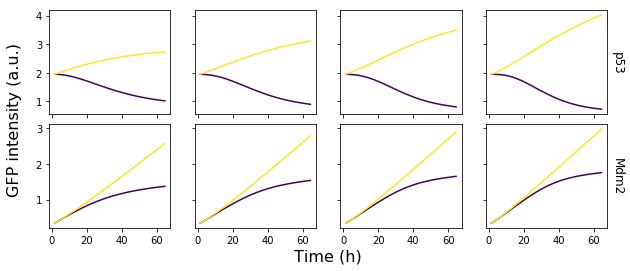

In [759]:
viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,len(rlist))
viridis(reps[1])

#solList = [scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]]
varnames = ["p53","Mdm2"]
title = ""

nrows = 4
ncols = 4

fig, ax = plt.subplots(len(varnames),ncols,sharex=True, sharey='row')

for a,r in enumerate(rlist):
    b = a #abs(a-len(rlist)+1)
    #solList = rscaled_sols[a]
    solList = rsols[a]
    for i,sol in enumerate(solList):
        #ax[i].plot(t*1.5,sol[:,0], color = viridis(reps[b])) #"#000000")
        ax[0,i].plot(t*1.5,sol[:,2]+sol[:,3], color = viridis(reps[b])) #"#000000")
        ax[1,i].plot(t*1.5,sol[:,4], color = viridis(reps[b])) #"#000000")

    ax[0,ncols-1].set_ylabel(varnames[0], rotation = -90, fontsize = 12)
    ax[0,ncols-1].yaxis.set_label_coords(1.03,0.5)
    ax[1,ncols-1].set_ylabel(varnames[1], rotation = -90, fontsize = 12)
    ax[1,ncols-1].yaxis.set_label_coords(1.03,0.5)

# for row in range(0,nrows):
#     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
#     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.suptitle(title, fontsize = 18)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("GFP intensity (a.u.)", fontsize=16)


In [ ]:
# Change r and checkout result on p53 protein at 0 to 5 uM with other mdm2-feedback r effect

In [347]:
### MDM2 knockdown 2
# Define ODE model
def mdm2_knockdown_r(z,t,args):
    # Define ODE model
    [sFunction, tau, s_init,r] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,tau,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2 = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - r * Vm_p53 * P53 / (Km_p53 + (P53 * (1+(MDM2/(Ki)))))
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - r * Vm_p53p * P53P / (Km_p53p + (P53P * (1+(MDM2/(Ki)))))
    
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2] 
    return dzdt

Vm_p53 = kd_p53_by_mdm2
Vm_p53p = kd_p53p_by_mdm2
Km_p53 = 1
Km_p53p = 1
Ki = 0.5

# rlist
rlist = [0,0.25,0.5,0.75,1]

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss]

# time points
t = np.linspace(1,43,43)

stressLevels = [0,EC1,EC2,EC3]

rsols = list()
for r in rlist:
    #print(r)
    sols = list()
    for stressLevel in stressLevels:
        # solve ODE
        #print(stressLevel)
        dzdt = odeint(mdm2_knockdown_r,z,t, args = ([sFunction,tau1,stressLevel,r],))
        sols.append(dzdt)
    rsols.append(sols)

In [348]:
rscaled_sols = []
for i,r in enumerate(rlist):
    obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']
    scaled_sols = list()
    for dosei in range(0,len(stressLevels)):
        scaled_sols.append(np.zeros([43,len(obsStateVarList)]))
    for dosei in range(0,len(stressLevels)):
        scaled_sols[dosei][:,0] = sf_p53 * (rsols[i][dosei][:,2] + rsols[i][dosei][:,3]) + offset_p53
        scaled_sols[dosei][:,1] = sf_mdm2 * (rsols[i][dosei][:,4]) + offset_mdm2
        scaled_sols[dosei][:,2] = sf_p21 * (rsols[i][dosei][:,5]) + offset_p21
        scaled_sols[dosei][:,3] = sf_btg2 * (rsols[i][dosei][:,6]) + offset_btg2
    rscaled_sols.append(scaled_sols)

Text(0, 0.5, 'GFP intensity (a.u.)')

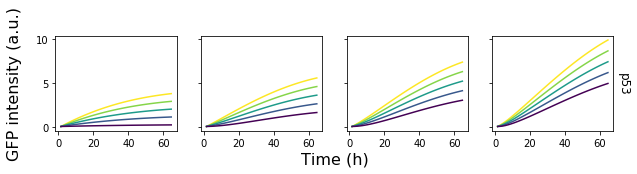

In [349]:
viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,len(rlist))
viridis(reps[1])

#solList = [scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]]
varnames = ["p53","mdm2","p21","btg2"]
ylims = [[0,0.225],[0,0.04]]
title = ""

nrows = 4
ncols = 4

fig, ax = plt.subplots(1,ncols,sharex=True, sharey='row')

for a,r in enumerate(rlist):
    b = abs(a-len(rlist)+1)
    solList = rscaled_sols[a]
    for i,sol in enumerate(solList):
        ax[i].plot(t*1.5,sol[:,0], color = viridis(reps[b])) #"#000000")
        #ax[row,i].set_ylim(ylims[row])

    ax[ncols-1].set_ylabel(varnames[0], rotation = -90, fontsize = 12)
    ax[ncols-1].yaxis.set_label_coords(1.03,0.5)

# for row in range(0,nrows):
#     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
#     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(1.75)
fig.set_figwidth(10)
fig.suptitle(title, fontsize = 18)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("GFP intensity (a.u.)", fontsize=16)

In [ ]:
# Include Nutlin as resource and checkout result on p53 protein at 0 to 5 uM with other mdm2-feedback r effect

In [691]:
### MDM2 knockdown 2
# Define ODE model
def mdm2_knockdown_r(z,t,args):
    # Define ODE model
    [sFunction, tau, s_init] = args

    # Molecular model
    ## Upstream of p53 ##
    S = sFunction(s_init,tau,t)
    
    # Initial states 
    DD,P53rna,P53,P53P,MDM2,P21,BTG2,Nut,C = z
    
    # ODEs
    dDD = ks_dd - kd_dd * DD * P53P + S
    dP53rna = ks_rna - kd_rna * P53rna
    dP53 = ks_p53 * P53rna + dephos * P53P - phos * P53 * DD - kd_p53 * P53 - kd_p53_by_mdm2 * MDM2  * P53
    dP53P = phos * P53 * DD - dephos * P53P - kd_p53p * P53P - kd_p53p_by_mdm2 * MDM2  * P53P
    dMDM2 = ks_mdm2 + (ks_mdm2_by_p53p * P53P**4) / (Km_mdm2**4 + P53P**4) - kd_mdm2 * MDM2 - kbind_nut_mdm2 * Nut * MDM2**n #/ (Km_nut * Km_mdm2 + Nut * Km_mdm2 + MDM2 * Km_nut + Nut * MDM2)
    dP21 = ks_p21 + (ks_p21_by_p53p * P53P**4) / (Km_p21**4 + P53P**4) - kd_p21 * P21
    dBTG2 = ks_btg2 + (ks_btg2_by_p53p * P53P**4) / (Km_btg2**4 + P53P**4) - kd_btg2 * BTG2
    dNut = - kbind_nut_mdm2 * Nut * MDM2**n #/ (Km_nut * Km_mdm2 + Nut * Km_mdm2 + MDM2 * Km_nut + Nut * MDM2)
    dC = kbind_nut_mdm2 * Nut * MDM2**n #/ (Km_nut * Km_mdm2 + Nut * Km_mdm2 + MDM2 * Km_nut + Nut * MDM2)

    # Output
    dzdt = [dDD,dP53rna,dP53,dP53P, dMDM2,dP21,dBTG2, dNut, dC] 
    return dzdt

# rlist
rlist = [0,0.4]#[1, 0.75,0.5,0.25,0]

# Nutlin
kbind_nut_mdm2 = 15 #2
Km_nut = 5
Km_mdm2 = 1.05
C_init = 0
n=4

# initial condition
z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss, Nut_init, C_init]

# time points
t = np.linspace(1,43,43)

stressLevels = [0,EC1,EC2,EC3]

rsols = list()
for r in rlist:
    Nut_init = r
    z = [DD_ss,P53rna_ss,P53_ss,P53P_ss,MDM2_ss,P21_ss,BTG2_ss, Nut_init, C_init]
    #print(r)
    sols = list()
    for stressLevel in stressLevels:
        # solve ODE
        #print(stressLevel)
        dzdt = odeint(mdm2_knockdown_r,z,t, args = ([sFunction,tau1,stressLevel],))
        sols.append(dzdt)
    rsols.append(sols)

In [692]:
rscaled_sols = []
for i,r in enumerate(rlist):
    obsStateVarList = ['p53', 'MDM2', 'p21', 'BTG2']
    scaled_sols = list()
    for dosei in range(0,len(stressLevels)):
        scaled_sols.append(np.zeros([43,len(obsStateVarList)]))
    for dosei in range(0,len(stressLevels)):
        scaled_sols[dosei][:,0] = sf_p53 * (rsols[i][dosei][:,2] + rsols[i][dosei][:,3]) + offset_p53
        scaled_sols[dosei][:,1] = sf_mdm2 * (rsols[i][dosei][:,4]) + offset_mdm2
        scaled_sols[dosei][:,2] = sf_p21 * (rsols[i][dosei][:,5]) + offset_p21
        scaled_sols[dosei][:,3] = sf_btg2 * (rsols[i][dosei][:,6]) + offset_btg2
    rscaled_sols.append(scaled_sols)

Text(0, 0.5, 'GFP intensity (a.u.)')

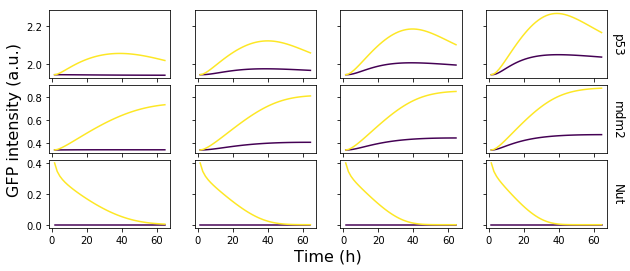

In [693]:
viridis = cm.get_cmap('viridis', 12)
reps = np.linspace(0,1,len(rlist))
viridis(reps[1])

#solList = [scaled_sols[0],scaled_sols[1],scaled_sols[2],scaled_sols[3]]
varnames = ["p53","mdm2","Nut","btg2"]
ylims = [[0,0.225],[0,0.04]]
title = ""

nrows = 4
ncols = 4

fig, ax = plt.subplots(3,ncols,sharex=True, sharey='row')

for a,r in enumerate(rlist):
    b = a #abs(a-len(rlist)+1)
    #solList = rscaled_sols[a]
    solList = rsols[a]
    for i,sol in enumerate(solList):
        #ax[i].plot(t*1.5,sol[:,0], color = viridis(reps[b])) #"#000000")
        ax[0,i].plot(t*1.5,sol[:,2]+sol[:,3], color = viridis(reps[b])) #"#000000")
        ax[1,i].plot(t*1.5,sol[:,4]+sol[:,8], color = viridis(reps[b])) #"#000000")
        ax[2,i].plot(t*1.5,sol[:,7], color = viridis(reps[b])) #"#000000")

    ax[0,ncols-1].set_ylabel(varnames[0], rotation = -90, fontsize = 12)
    ax[0,ncols-1].yaxis.set_label_coords(1.03,0.5)
    ax[1,ncols-1].set_ylabel(varnames[1], rotation = -90, fontsize = 12)
    ax[1,ncols-1].yaxis.set_label_coords(1.03,0.5)
    ax[2,ncols-1].set_ylabel(varnames[2], rotation = -90, fontsize = 12)
    ax[2,ncols-1].yaxis.set_label_coords(1.03,0.5)

# for row in range(0,nrows):
#     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
#     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
fig.subplots_adjust(hspace=0.1)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.suptitle(title, fontsize = 18)

# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.grid(False)
plt.xlabel("Time (h)", fontsize=16)
plt.ylabel("GFP intensity (a.u.)", fontsize=16)

# fig, ax = plt.subplots(1,ncols,sharex=True, sharey='row')

# for a,r in enumerate(rlist):
#     b = a #abs(a-len(rlist)+1)
#     #solList = rscaled_sols[a]
#     solList = rsols[a]
#     for i,sol in enumerate(solList):
#         #ax[i].plot(t*1.5,sol[:,1], color = viridis(reps[b])) #"#000000")
#         ax[i].plot(t*1.5,sol[:,4]+sol[:,8], color = viridis(reps[b])) #"#000000")

#     ax[ncols-1].set_ylabel(varnames[1], rotation = -90, fontsize = 12)
#     ax[ncols-1].yaxis.set_label_coords(1.03,0.5)

# # for row in range(0,nrows):
# #     ax[row,ncols-1].set_ylabel(varnames[row], rotation = -90, fontsize = 12)
# #     ax[row,ncols-1].yaxis.set_label_coords(1.03,0.5)

# # add a big axes, hide frame
# fig.add_subplot(111, frameon=False)
# fig.subplots_adjust(hspace=0.1)
# fig.set_figheight(1.75)
# fig.set_figwidth(10)
# fig.suptitle(title, fontsize = 18)

# # hide tick and tick label of the big axes
# plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
# plt.grid(False)
# plt.xlabel("Time (h)", fontsize=16)
# plt.ylabel("GFP intensity (a.u.)", fontsize=16)